# Direct Solvers and Matrix Decompositions

This script contains solutions to the "Direct Solvers and Matrix Decompositions" lecture on day 1.

## Matrix Form of Equations

Going through the examples from the theoretical part of the lecture.

In [11]:
# defining the example matrices 
A = [3 0 2; 3 0 -3; 0 1 -1]
B = [1 1 1; 2 4 2; 7 10 7]

# calculating their matrix inverse
inv(A)
#inv(B)

3×3 Array{Float64,2}:
 0.2   0.133333  -0.0
 0.2  -0.2        1.0
 0.2  -0.2        0.0

Solving the associated problems:

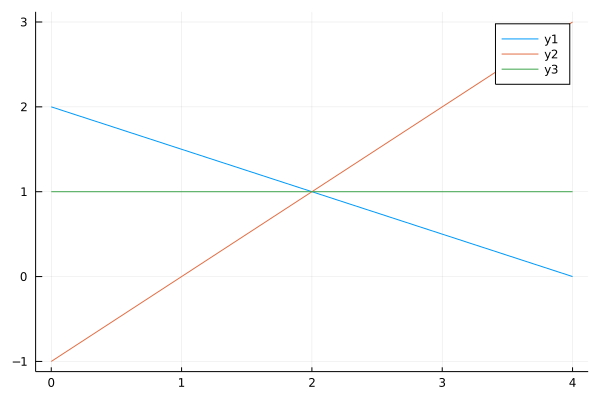

In [21]:
# plotting three lines to see whether system of equation is solvable
using Plots
gr()


y1(x) = 2 - 0.5*x
y2(x) = x - 1
y3(x) = 1

x = 0:0.1:4

plot(x, y1.(x))
plot!(x, y2.(x))
plot!(x, y3.(x))

In [8]:
# writing a function to solve a LSE with an upper-triangular matrix
using LinearAlgebra

dims = 5
testMat = UpperTriangular(randn(dims, dims))
testVec = randn(dims)

function triagSolver(A, b)
    
    # get number of rows/columns
    n = size(A,1)
    
    # initialise array to store results
    x = zeros(n)
    
    # iterate backwards through rows
    for idx in n:-1:1
        
        # evaluate and subtract the entries corresponding to the 
        # already evaluated elements, i.e. (x_n), (x_n, x_n-1), ...
        item = (b[idx] - dot(A[idx, idx:n], x[idx:n]))/A[idx, idx]
        x[idx] = item
            
    end
    
    # return the solution
    x   
    
end

if norm(triagSolver(testMat, testVec) - testMat\testVec) < 1e-10
    println("The implementation is correct.")
else
    println("The implementation is not correct.")
end

The implementation is correct.


## Gaussian Elimination

In [9]:
# implementing Gaussian elimination
using LinearAlgebra

dims = 5
testMat = rand(1.:9., dims, dims)
testVec = rand(1.:9., dims)

function gaussElim(A, b)
    
    nRows, nCols = size(A)
    
    # initialise pivot indices
    pivotRow = 1
    pivotCol = 1
    
    while pivotRow <= nRows && pivotCol <= nCols
        
        # find the largest element in the pivot column
        _, maxIdx = findmax(abs.(A[pivotRow:nRows, pivotCol]))
        maxIdx += pivotRow-1
        
        # if the pivot column is empty, skip to the next
        if A[maxIdx, pivotCol] == 0
            pivotCol += 1
            
        else
            
            # move the row with the largest pivot to the top
            A[[maxIdx, pivotRow], :] = A[[pivotRow, maxIdx], :]
            
            # iterate through non-pivot rows
            for row in pivotRow+1:nRows
                
                # calculate ratios of non-pivots to pivot  
                f = A[row, pivotCol] / A[pivotRow, pivotCol]
                
                # set non-pivot entries to zero
                A[row, pivotCol] = 0
                
                # subtract the rest of the pivot row from non-pivot rows
                for col in pivotCol+1:nCols
                    A[row, col] = A[row, col] - A[pivotRow, col]*f
                end
            end
            
            # increment pivot row and columns
            pivotRow += 1
            pivotCol += 1
        end
    end  
    
    # calculate the solution
    triagSolver(A, b)
    
end

if norm(gaussElim(testMat, testVec) - testMat\testVec) < 1e-10
    println("The implementation is correct.")
else
    println("The implementation is not correct.")
end

The implementation is correct.


In [10]:
# playing aroung with condition numbers
using LinearAlgebra

A = [4.5 3.1; 1.6 1.1]

b1 = [19.249, 6.843]
b2 = [19.25, 6.84]

# solving the equation systems 
x1 = A\b1
x2 = A\b2
    
#calculating the mean differences
diff_b = round(sum(abs.(b1-b2))/length(b1), digits=3)
diff_x = round(sum(abs.(x1-x2))/length(x1), digits=3)

println("The mean difference before solving was $diff_b, while after solving it increased to $diff_x.")

# calculating the condition number
condNum = round(cond(A), digits=1)

println("The condition number of the coefficient matrix is $condNum")

The mean difference before solving was 0.002, while after solving it increased to 1.275.
The condition number of the coefficient matrix is 3363.0


## Matrix Decompositions

### LU Decomposition

In [144]:
# adapting the Gaussian elimination algorithm to LU factorisation
using LinearAlgebra

test = [2. 5. 8. 7.; 5. 2. 2. 8.; 7. 5. 6. 6.; 5. 4. 4. 8.]

function luFact(A)
    
    nRows, nCols = size(A)
    
    # initialise lower and upper triangular matrices and permutation array
    lowerTriag = zeros(nRows, nCols)
    upperTriag = copy(A)
    permutationArray = [1 2 3 4]
    
    # initialise pivot indices
    pivotRow = 1
    pivotCol = 1
    
    while pivotRow <= nRows && pivotCol <= nCols
        
        # find the largest element in the pivot column
        _, maxIdx = findmax(abs.(upperTriag[pivotRow:nRows, pivotCol]))
        maxIdx += pivotRow-1

        # move the row with the largest pivot to the top
        upperTriag[[maxIdx, pivotRow], :] = upperTriag[[pivotRow, maxIdx], :]
        lowerTriag[[maxIdx, pivotRow], :] = lowerTriag[[pivotRow, maxIdx], :]
        
        # repeat shuffle in the permutation array
        permutationArray[[maxIdx, pivotRow]] = permutationArray[[pivotRow, maxIdx]]
        
        # create corresponding column in lower triangluar matrix
        lowerTriag[pivotRow:nRows, pivotCol] = upperTriag[pivotRow:nRows, pivotCol]./upperTriag[pivotRow, pivotCol]
        
        # use column replacement to create zeros below pivot
        for row in pivotRow+1:nRows

            # calculate ratios of non-pivots to pivot  
            f = upperTriag[row, pivotCol] / upperTriag[pivotRow, pivotCol]    
            
            # set non-pivot entries to zero
            upperTriag[row, pivotCol] = 0

            # subtract the rest of the pivot row from non-pivot rows
            for col in pivotCol+1:nCols
                upperTriag[row, col] = upperTriag[row, col] - upperTriag[pivotRow, col]*f
            end
        end
        
        # increment pivot row and columns
        pivotRow += 1
        pivotCol += 1
        
    end  
    
    # calculate permutational matrix
    permMat = zeros(nRows, nCols)
    for i in 1:nCols
        permMat[permutationArray[i], i] = 1
    end
    
    # return permutational, upper and lower triagonal matrices
    lowerTriag, upperTriag, permMat
    
end

# check against built-in factorisation and check that PLU = A
L, U, P = luFact(test)
F = lu(test)

if norm(L-F.L) < 1e-10 && norm(U-F.U) < 1e-10 && norm(P*L*U-test) < 1e-10
    println("The implementation is correct.")
else
    println("The implementation is not correct.")
end

The implementation is correct.


### Cholesky decomposition (in progress!)

In [81]:
# sampling from a multi-variate Gaussian through the Choleski decomposition
using LinearAlgebra

function independentNormal(sigma1, n)
    x = sigma1.*randn(n)
end

function createCovar(sigma1, sigma2, n)
    Sigma = [sigma1^2 * exp(-(i-j)^2 / sigma2^2) for i in 1:n, j in 1:n]
    Sigma += Diagonal(fill(1e-5, n))
end

function multivariateNormal(covar)
    C = cholesky(covar)
    x = C.L * randn(size(covar, 1))
end

multivariateNormal (generic function with 1 method)

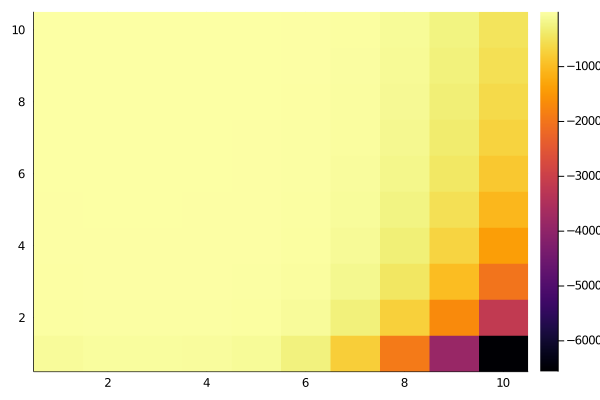

In [201]:
# calculating the maximum likelihood estimates of the covariance parameters
using Statistics, StatsBase, LinearAlgebra, Plots

gr()

function mlEstimate(covar, data)
    
    numDims = size(covar, 1)
    
    # calculate the Cholesky decomposition of the covariance matrix
    C = cholesky(covar)
    
    # estimate the determinant and inverse
    determinant = det(C.L)*det(C.L')
    inverse = inv(C.L')*inv(C.L)
    
    # calculate the mean log likelihood over the entire dataset
    sumSigma = 0
    
    for x in data
        sumSigma += x'*inverse*x 
    end
    
    logLikelihood = -0.5 *(numDims*log(determinant) + sumSigma)
    
end

# setting parameters
dims = 10
sigma1 = 5
sigma2 = 5

# generating a dataset
dataset_size = 1e3
Sigma = createCovar(sigma1, sigma2, dims)
dataset = [multivariateNormal(Sigma) for i in 1:dataset_size]

# screening parameters and plotting their log-likelihood
test_sigma1 = 1:1:10
test_sigma2 = 1:1:10
likelihood = zeros(length(test_sigma1), length(test_sigma2))

for sig1 in 1:length(test_sigma1), sig2 in 1:length(test_sigma2)
    
    # generating a covariance with current sigmas
    covariance = createCovar(test_sigma1[sig1], test_sigma2[sig2], dims)
    
    # calculating how well the covariance explains the dataset
    likelihood[sig1, sig2] = mlEstimate(covariance, dataset)
    #likelihood[sig1, sig2] = norm(cov(dataset) - covariance)
end

heatmap(test_sigma1, test_sigma2, likelihood)

### QR Decomposition

In [223]:
# fitting an overdetermined model to Oxford weather data
using CSV, LinearAlgebra

# reading in the weather data
data = CSV.File("oxford_weather.csv")
months = data.month
hours = data.hoursSun

# creating a feature map to fit the model
A = vcat([[x^2 x 1] for x in months]...)

# performing QR decomposition
Q,R = qr(A)

# solving the LS problem
x = inv(R)*Q'*hours

if norm(x - A\hours) < 1e-10
    println("The implementation is correct.")
else
    println("The implementation is not correct.")
end
    
    
Q'

The implementation is correct.


3×3 Array{Float64,2}:
 -0.000445483   0.00173282  -0.00241371
  0.0          -0.0172911    0.0362057
  0.0           0.0         -0.113445